# Natural Language Processing (NLP) and Spam Detection

A subfield of linguistics, computer science, information engineering, and artifical intelligence. It focuses on the interactions between computers and human languages. The goal is to study how to program computers to process and analyze large amounts of natural language data.

NLP is the driving force behind many applications:
* Google Translate
* Word processors that employ NLP to check grammatical accuracy of texts
* Interactive Voice Response (IVR) applications used in call centers
* Personal assistant applications including OK Google, Siri, Cortana, and Alexa

## NLP is Difficult

The rules that dictate the exchange of information amoung languages are not simple for computers to understand. Some of these rules are high-level and abstract, for example, sarcasm. Some of these rules are low-level, for example, using <i>s<i> for plurality.

## How does NLP Work?

* Applies algorithms to identify and extract the natural language rules from unstructured language data converted into a form that computer can understand
* Computers utilize algorithms to extract meaning associated with every sentence and collect the essential data from them
* Computer can fail to understand the meaning of a sentence and leading to obscure results

## NLP Techniques

* Syntactic analysis: the arrangement of words in a sentence such that they make grammatical sense
    * lemmatization: reducing the various inflected forms a word into a single form
    * morphological segmenation: dividing words into individual units called morphemes
    * word segmentation: involves dividing a large piece of continuous text into distinct units
    * part-of-speech taggingL identifying the part of speech for evey word
    * parsing: grammatical analysis for the provided sentence
    * sentence breaking: placing sentence boundaries on a large piece of text
    * stemming: cutting the inflected words to their root form

* Semantic analysis: assess how the natural language aligns with the grammatical rules
    * name entity recognition (NER): determining the parts of text that can be identified and categorized into preset groups
    * word sense disambiguation: giving meaning to a word based on the context
    * natural language generation: using databases to derive semantic intentions and convert them into human language


### NLP & Security

Come back to explain this


### Dataset Description (Create a Better Dataset)

https://www.kaggle.com/venky73/spam-mails-dataset/downloads/spam-mails-dataset.zip/1

In [1]:
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import re
import itertools
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package wordnet to /home/iti/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/iti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/iti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/iti/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# read the dataset and prepare for basic process in  nlp
df = pd.read_csv('data/spam_ham_dataset.csv')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


### cleaning data
* remove web links from the text
* correcting misspelled words
* remove punctuations from the text
* remove apostrophes from the text to correct words like i'm to I am

In [3]:
def clean_data(sentence):
    ## removing web links
    s = [ re.sub(r'http\S+', '', sentence.lower())]
    ## removing words like gooood and poooor to good and poor
    s = [''.join(''.join(s)[:2] for _, s in itertools.groupby(s[0]))]
    ## removing appostophes
    # s = [remove_appostophes(s[0])]
    ## removing punctuations from the code 
    s = [remove_punctuations(s[0])]
    return s[0]

In [4]:
def remove_punctuations(my_str):
    punctuations = '''!()-[]{};:'"\,./?@#$%^&@*_~'''
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct

In [5]:
df['text'] = df['text'].apply(clean_data)

### Understanding text data and finding important words

Tokenization break each sentence into individual words into an array. Every single word is known as tokens. After getting each token, we try to get each token into its most basic form. Remove stop words, they are very frequent in text and hardly lead to any interpretation about any message being spam or not

In [6]:
# Break sentence into individual tokens and then lemmatizes those words
# remove stop words from the tokens we have and return these tokens
def my_tokeniser(s):
    lemmatizer = WordNetLemmatizer()
    stop = set(stopwords.words('english'))
    tokens = nltk.tokenize.word_tokenize(s)
    tokens = [t for t in tokens if len(t)>2]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [t for t in tokens if t not in stop]
    tokens.remove('subject')
    tokens = ','.join(tokens)
    return tokens

In [7]:
df['text'] = df['text'].apply(my_tokeniser)

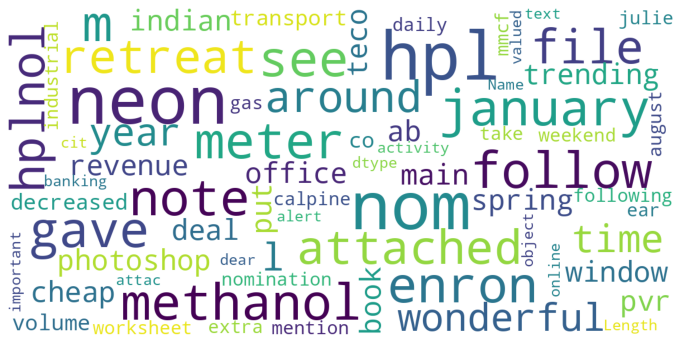

In [8]:
# Word Cloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

# Word cloud for all emails
show_wordcloud(df.text)

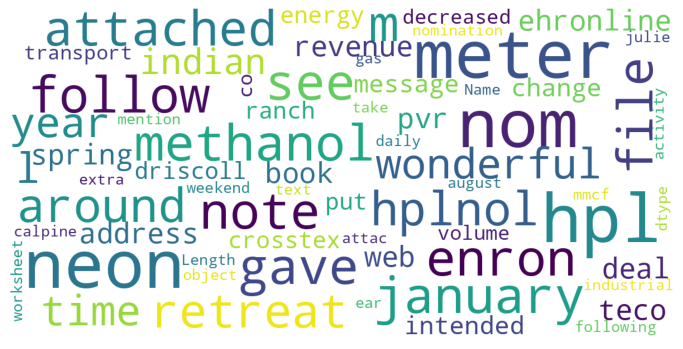

In [9]:
show_wordcloud(df.text[df.label == 'ham'])

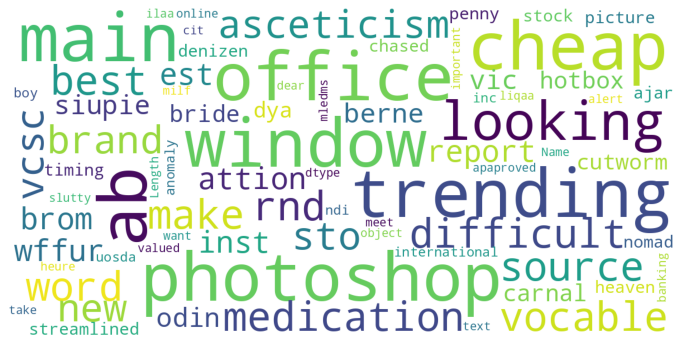

In [10]:
show_wordcloud(df.text[df.label == 'spam'])

### Understanding n-grams

n-grams is a contiguous sequences of n items from a given sequence of text. Given a setence, we can construct a list of n-grams from s finding pairs of words that occur next to each other. A consecutive pair of three words is known as tri-grams. This helps us understand how exactly a sequence of tokens together determines whether an incoming message is a spam or not. In NLP, n-grams hold a lot of important as they determine how sequence sof words affect the meaning of a sentence.

Find out the most common bi-grams and tri-grams from the messages, in the datset separately for both spam and non-spam messages and consecutively will have a look at most commonly occuring sequences of text in each category

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
word_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df['text'])
frequencies = sum(sparse_matrix).toarray()[0]
df1 = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

/home/iti/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:>

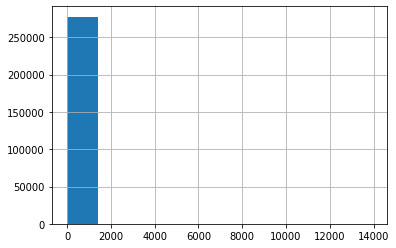

In [12]:
df1['frequency'].hist()

### Vectorizing the Text

TF-IDF vectorizer (Term Frequency - Inverse Document Frequency), a similar embedding technique which takes into account the importance of each term to document


The TF-IDF vectorizer was chosen for its simplicity and efficiency in vectorizing documents such as as text messages

TF-IDF vectorizes documents by calculating a TF-IDF statistics between the document and each term in the vocabulary. The document vector is constructured by using each statistic as an element in the vector. 

In [13]:
## Split our data into training set and testing set
## 10% of our data is allocated for testing
df = df.drop(columns=['Unnamed: 0', 'label'])
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label_num'], test_size = 0.1, random_state = 1)
# training the vectorizer 
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)

## Build and Testing the Classifier

Support Vector Machine

[[370   7]
 [  0 141]]


<ipython-input-14-6f943aed3553>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-14-6f943aed3553>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


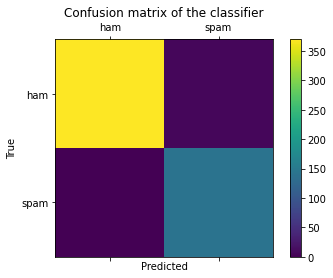

In [14]:
svm = svm.SVC(C=1000)
svm.fit(X_train, y_train)

labels = ['ham', 'spam']
# Test it
X_test = vectorizer.transform(X_test)
y_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()